# Imports

In [23]:
import numpy as np
from scipy.io import loadmat
from ternary.helpers import project_sequence

import tensorflow as tf

from scipy.spatial.distance import pdist, squareform

from sklearn.manifold import spectral_embedding
from sklearn.mixture import GaussianMixture
from matplotlib import path
import gpflow

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import ternary

from applied_active_learning_220608a import GRF_RiskMin_simplified

from sklearn.metrics import fowlkes_mallows_score

In [4]:
# import the experimental data, including the...
experimental_data = loadmat('FeGaPd_full_data_220104a.mat')

# ..."true" labels from the data set, ...
true_labels = experimental_data['labels_col'][0][1].flatten()

# ...composition data in cartesian coordinates, ...
composition = experimental_data['C']
idx = [1, 2, 0]
cartesian = np.array(list(zip(*project_sequence(composition[:, idx]))))

# ...and x ray diffraction data
xrd = experimental_data['X'][:, 631:1181]

# Gaussian Process Classification Methods

In [5]:
def similarity_matrix(X, metric, sigma=1):
    '''
    Calculate and return the similarity matrix used in spectral clustering.

    Parameters
    ----------
    X: m x n matrix - m rows of n dimensional data
    metric: distance metric passed to scipy.spatial.distance.pdist()
    sigma: scaling factor for Gaussian radial basis function (default=1)
    '''

    distance = squareform(pdist(X, metric))
    W = np.exp(-(distance**2) / (2*sigma**2))
    return W

In [6]:
def phase_mapping(X, num_clusters, random_state):
    '''
    Cluster data using spectral clustering and a Gaussian mixture model

    Parameters
    ----------
    X: m x n matrix - m rows of n dimensional data
    num_clusters: number of groups to cluster data into
    random_state: a numpy RandomState for reproducibility 

    Returns
    -------
    cl: clustering labels for each sample
    cluster_prob: the probability for each sample to belong to each cluster
    '''

    K = similarity_matrix(X, 'cosine')

    if X.shape[0] <= num_clusters:
        # fewer data points than clusters, each point gets its own cluster
        cluster_prob = np.eye(X.shape[0])
    else:
        x_se = spectral_embedding(adjacency=K,
                                  n_components=num_clusters,
                                  random_state=random_state)
        model = GaussianMixture(n_components=num_clusters,
                                covariance_type='diag',
                                n_init=10,
                                random_state=random_state).fit(x_se)

        cluster_prob = model.predict_proba(x_se)

    cl = np.argmax(cluster_prob, axis=1).flatten()
    return cl, cluster_prob


In [7]:
def get_user_labels(points):
    '''
    Return the user labels created using the provided user input
    
    Parameters
    ----------
    points: a list of tuples of the user input cartesian coordinates
    '''

    if len(points) < 2:
        raise ValueError('User didn\'t add enough points.')
    elif len(points) == 2:
        # user drew a line
        x1, y1 = points[0]
        x2, y2 = points[1]

        # calculate the distance between each point the line
        d = [(x-x1)*(y2-y1)-(y-y1)*(x2-x1) for (x, y) in cartesian]

        user_labels = [1 if distance > 0 else 0 for distance in d]
    else:
        # user draw a polygon
        polygon = path.Path(points)

        user_labels = polygon.contains_points(cartesian)
    
    return(np.array(user_labels))

In [8]:
def phase_mapping_with_input(X, num_clusters, random_state, points, measured):
    '''
    Cluster data using spectral clustering and a Gaussian mixture model

    Parameters
    ----------
    X: m x n matrix - m rows of n dimensional data
    num_clusters: number of groups to cluster data into
    random_state: a numpy RandomState for reproducibility
    points: a list of tuples of the user input cartesian coordinates
    measured: list of samples which have been measured

    Returns
    -------
    cl: clustering labels for each sample
    cluster_prob: the probability for each sample to belong to each cluster
    '''

    K = similarity_matrix(X, 'cosine')

    user_labels = np.expand_dims(get_user_labels(points)[measured], 1)

    # if len(points) == 2:
    if True:
        user_kernel = gpflow.kernels.SquaredExponential(lengthscales=0.001)
    else:
        user_kernel = gpflow.kernels.Linear()

    K += user_kernel.K(user_labels).numpy()

    if X.shape[0] <= num_clusters:
        # fewer data points than clusters, each point gets its own cluster
        cluster_prob = np.eye(X.shape[0])
    else:
        x_se = spectral_embedding(adjacency=K,
                                  n_components=num_clusters,
                                  random_state=random_state)
        model = GaussianMixture(n_components=num_clusters,
                                covariance_type='diag',
                                n_init=10,
                                random_state=random_state).fit(x_se)

        cluster_prob = model.predict_proba(x_se)

    cl = np.argmax(cluster_prob, axis=1).flatten()
    return cl, cluster_prob


In [9]:
def gpc_phasemapping(xy_curr, labels_curr, xy_full, num_clusters, 
                     weight_prior=None, points=None):
    '''
    Take clustering labels for the samples and then extrapolate them throughout
    composition space, segmenting the XY space into 'phase regions'.

    Parameters
    ----------
    xy_curr: cartesian coordinates of measured data points
    labels_curr: cluster labels for those data
    xy_full: cartesian coordinates of measured and new, query data points
    num_clusters: the number of clusters we're assuming exist
    weight_prior: variance coefficient factor of (optional) prior kernel

    Returns
    -------
    y_mean: data point label predictions
    y_variance: data point label variances
    f_mean: data point latent GP predictions
    f_variance: data point latent GP variances
    points: a list of tuples of the user input cartesian coordinates
    '''

    data = (xy_curr, labels_curr)

    composition_kernel = gpflow.kernels.Matern32(active_dims=[0, 1],
                                                 lengthscales=[0.2, 0.2],
                                                 variance=1)

    gpflow.utilities.set_trainable(composition_kernel.lengthscales, False)
    gpflow.utilities.set_trainable(composition_kernel.variance, False)

    if weight_prior is None:
        kernel = composition_kernel
    else:
        if len(points) == 2:
            # user input was a boundary
            prior_kernel = gpflow.kernels.SquaredExponential(
                active_dims=[2],
                lengthscales=0.001,
                variance=weight_prior)

            # fix all the kernel hyperparameters
            gpflow.utilities.set_trainable(prior_kernel.lengthscales, False)
            gpflow.utilities.set_trainable(prior_kernel.variance, False)
        else:
            # user input was a region
            prior_kernel = gpflow.kernels.Linear(active_dims=[2],
                                                 variance=weight_prior)

            gpflow.utilities.set_trainable(prior_kernel.variance, False)

        kernel = composition_kernel + prior_kernel

    invlink = gpflow.likelihoods.RobustMax(num_clusters)

    gpflow.utilities.set_trainable(invlink.epsilon, True)

    likelihood = gpflow.likelihoods.MultiClass(num_clusters, invlink=invlink)

    model = gpflow.models.VGP(data=data,
                              kernel=kernel,
                              likelihood=likelihood,
                              num_latent_gps=num_clusters)

    # hyperparameter optimization
    opt = gpflow.optimizers.Scipy()
    opt_result = opt.minimize(model.training_loss,
                              model.trainable_variables,
                              options={'maxiter': 1000})

    # Poisson process for the full XY coordinates
    y = model.predict_y(xy_full)
    y_mean = y[0].numpy()
    y_variance = y[1].numpy()

    # (non-squeezed) probabilistic function for class labels
    f = model.predict_f(xy_full)
    f_mean = f[0].numpy()
    f_variance = f[1].numpy()

    return y_mean, y_variance, f_mean, f_variance


In [10]:
def get_hitl_labels(user_points, measured_indices):
    '''
    Return the 5th iteration clustering results using the provided user input
    
    Parameters
    ----------
    user_points: a list of tuples of the user input cartesian coordinates
    measured_indices: a list of indices of the measured compositions
    '''

    user_labels = get_user_labels(user_points)

    if len(user_points) < 2:
        raise ValueError('User didn\'t add enough points.')
    elif len(user_points) == 2:
        # user drew a line
        x1, y1 = user_points[0]
        x2, y2 = user_points[1]

        # calculate the distance between each point the line
        d = [(x-x1)*(y2-y1)-(y-y1)*(x2-x1) for (x, y) in cartesian]

        user_labels = [1 if distance > 0 else 0 for distance in d]
    else:
        # user draw a polygon
        polygon = path.Path(user_points)

        user_labels = polygon.contains_points(cartesian)
    
    labels = [0, 1, 2, 3, 4]

    # use the user labels as input
    data_with_prior = np.column_stack((cartesian, user_labels))

    y_mean, _, _, _ = gpc_phasemapping(data_with_prior[measured_indices, :],
                                       labels,
                                       data_with_prior,
                                       5,
                                       weight_prior=1,
                                       points=user_points)

    return(y_mean)


# Random Samples

In [16]:
# user_points = [(0.2, 0.3), (0.4, 0.3)]
user_points = [(0.07, 0.05), (0.16, 0.25), (0.3, 0.25), (0.1, 0.03)]

num_samples = 100
num_compositions = composition.shape[0]

# initialize result arrays
measured_indices = np.zeros((num_samples, 5), np.int16)

control_labels = np.zeros((num_samples, num_compositions))
control_acquisition = np.zeros((num_samples, num_compositions))

hitl_labels = np.zeros((num_samples, num_compositions))
hitl_acquisition = np.zeros((num_samples, num_compositions))

# perform random experiments
for i in range(num_samples):
    # generate random measurements
    measured_indices[i, :] = np.random.choice(a=num_compositions, 
                                              size=(1, 5),
                                              replace=False)

    # compute control prediction and acquisition function values 
    y_mean, _, _, _ = gpc_phasemapping(cartesian[measured_indices[i, :], :],
                                       [0, 1, 2, 3, 4],
                                       cartesian,
                                       5)
    control_labels[i, :] = np.argmax(y_mean, 1)

    _, risks = GRF_RiskMin_simplified(cartesian, y_mean, measured_indices[i, :])
    control_acquisition[i, :] = risks

    # compute the hitl prediction and acquisition function values
    input_y_mean = get_hitl_labels(user_points, measured_indices[i, :])
    hitl_labels[i, :] = np.argmax(input_y_mean, 1)

    _, input_risks = GRF_RiskMin_simplified(cartesian,
                                                input_y_mean,
                                                measured_indices[i, :])
    hitl_acquisition[i, :] = input_risks

# Save the results

In [29]:
prefix = 'boundary'

np.savetxt(fname='quantitative_results/' + prefix + '_measured_indices.txt',
           X=measured_indices,
           fmt='%d')
np.savetxt(fname='quantitative_results/' + prefix + '_control_acquisition.txt',
           X=control_acquisition,
           fmt='%f')
np.savetxt(fname='quantitative_results/' + prefix + '_control_labels.txt',
           X=control_labels,
           fmt='%f')
np.savetxt(fname='quantitative_results/' + prefix + '_hitl_acquisition.txt',
           X=hitl_acquisition,
           fmt='%f')
np.savetxt(fname='quantitative_results/' + prefix + '_hitl_labels.txt',
           X=hitl_labels,
           fmt='%f')

# Compute FMI

In [30]:
# get "true" labels
true_labels = experimental_data['labels_col'][0][1].flatten()

In [31]:
control_scores = np.zeros(num_samples)
hitl_scores = np.zeros(num_samples)

for i in range(num_samples):
    control_scores[i] = fowlkes_mallows_score(true_labels, control_labels[i])
    hitl_scores[i] = fowlkes_mallows_score(true_labels, hitl_labels[i])

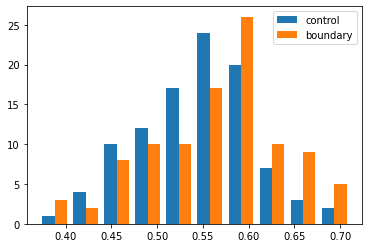

In [32]:
fig, ax = plt.subplots()

ax.hist([control_scores, hitl_scores], label=['control', prefix])

ax.legend()

plt.show()

In [33]:
np.savetxt(fname='quantitative_results/' + prefix + '_control_scores.txt',
           X=control_scores,
           fmt='%f')
np.savetxt(fname='quantitative_results/' + prefix + '_hitl_scores.txt',
           X=hitl_scores,
           fmt='%f')